In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import json
import pandas as pd
import copy
import sys
from glob import glob
from copy import deepcopy
from tqdm import tqdm_notebook as tqdm
%run ./plot_functions.ipynb
sys.path.insert(0, '../src/')


output_path =  ../output/figures
plt = single_column_plt_params(plt)
plt = double_column_plt_params(plt)


In [2]:
from analyze_utilities import *
# from dataset_utilities import create_cifar10_dataloaders
from distributions_metrics import *
plt = single_column_plt_params(plt)


# ODIN Baseline


ODIN:
    AUROC   AP-In  AP-Out  KL Divergence  KL in P_lamb
0  98.862  98.914  98.868          0.542         0.139


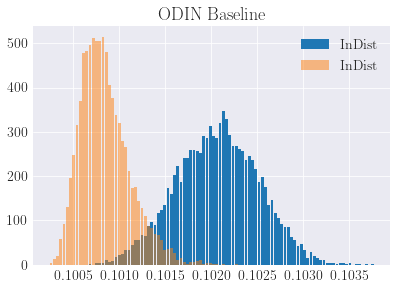

In [3]:
# ODIN baseline: with pNML fraemwork
file_baseline_cifar10 = '../output/baseline_odin_densenet_cifar10_cifar10_20190926_184650/results_baseline_odin_densenet_cifar10_cifar10_20190926_184650.json'
file_baseline_isun = '../output/baseline_odin_densenet_cifar10_isun_20190926_184648/results_baseline_odin_densenet_cifar10_isun_20190926_184648.json'

with open(file_baseline_cifar10) as data_file:
    ind_df = result_dict_to_erm_df(json.load(data_file), is_out_of_dist=True)
ind_df = ind_df.add_prefix('erm_')
ind_df.index = ind_df.index.astype(int)
ind_df_odin = ind_df.sort_index()
print()
with open(file_baseline_isun) as data_file:
    ood_df = result_dict_to_erm_df(json.load(data_file), is_out_of_dist=True)
ood_df = ood_df.add_prefix('erm_')
ood_df.index = ood_df.index.astype(int)
ood_df_odin = ood_df.sort_index()

# Baseline Max prob of ERM
y_score_ind = ind_df_odin[['erm_' + str(x) for x in range(10)]].max(axis=1).tolist() + \
    ood_df_odin[['erm_' + str(x) for x in range(10)]].max(axis=1).tolist()
y_true_ind = [True] * ind_df_odin.shape[0] + [False] * ood_df_odin.shape[0]
baseline_performance = calc_performance_in_out_dist(y_true_ind, y_score_ind)

y_score_ind = np.array(y_score_ind)
y_true_ind = np.array(y_true_ind)

print('ODIN:')
print(baseline_performance.round(3))

bins = 100
min_r = np.min(y_score_ind)
max_r = np.max(y_score_ind)
_, bins, _ = plt.hist(y_score_ind[y_true_ind], range=[
                      min_r, max_r], rwidth=0.8, bins=bins, label='InDist')
plt.hist(y_score_ind[np.logical_not(y_true_ind)], rwidth=0.9,
         alpha=0.5, bins=bins,  label='InDist')
plt.title('ODIN Baseline')
plt.legend()
plt.show()


# Linear regression

In [63]:
def compute_regret(x_m_train: np.ndarray, x_m_test: np.ndarray, lamb: float):
    n = x_m_train.shape[1]

    # SVD decomposition
    u, s, vh = np.linalg.svd(x_m_train)
    eta = s ** 2
    eta = eta[:, np.newaxis]

    # Calc mean regret
    x_t_u_2 = (x_m_test.T.dot(u)) ** 2
    div = x_t_u_2 / \
        (eta +
         lamb) if eta.shape[0] == x_t_u_2.shape[0] else x_t_u_2 / (eta.T + lamb)
    regret_all = np.log(1 + (1 / n) * div.sum(axis=1))
    return regret_all.tolist()
#     return div.sum(axis=1).tolist()


def plot_ood(regret_ind_list: list, regret_ood_list: list, dataset_name: str):
    min_r = np.min(regret_ind_list+regret_ood_list)
    max_r = np.max(regret_ind_list+regret_ood_list)
    _, bins, _ = plt.hist(regret_ind_list, bins=100,  range=[min_r, max_r],
                          label='InDist', rwidth=0.8)
    plt.hist(regret_ood_list, bins=bins, alpha=0.5,
             label='OutOfDist', rwidth=0.8)
    plt.title(dataset_name)
    plt.legend()
    plt.yscale('symlog')
    plt.show()


def analyze_ind_ood_regret(trainset_all: np.ndarray, train_labels: np.ndarray, testset_ind: np.ndarray, testset_ood: np.ndarray):
    regret_ind_list_all = []
    regret_ood_list_all = []

    for class_num in tqdm(np.unique(train_labels)):
        trainset = trainset_all[:, train_labels == class_num]
        regret_ind_list_all.append(compute_regret(
            trainset, testset_ind, lamb=0))
        regret_ood_list_all.append(compute_regret(
            trainset, testset_ood, lamb=0))

    regret_ind_np = np.asarray(regret_ind_list_all)
    regret_ood_np = np.asarray(regret_ood_list_all)

    regret_ind_list = regret_ind_np.min(axis=0).tolist()
    regret_ood_list = regret_ood_np.min(axis=0).tolist()

    y_score_ind = regret_ind_list + regret_ood_list
    y_score_ind = 1 - np.array(y_score_ind)
    y_true_ind = [True] * len(regret_ind_list) + [False] * len(regret_ood_list)
    performance = calc_performance_in_out_dist(y_true_ind, y_score_ind)

    return performance, regret_ind_list, regret_ood_list


def analyze_ind_ood_max_prob(ind_max_prob: np.ndarray, out_dist_max_prob: np.ndarray):
    ind_list = ind_max_prob.tolist()
    ood_list = out_dist_max_prob.tolist()
    y_score_ind = ind_max_prob.tolist() + out_dist_max_prob.tolist()
    y_true_ind = [True] * len(ind_list) + [False] * len(ood_list)
    performance = calc_performance_in_out_dist(y_true_ind, y_score_ind)

    return performance, regret_ind_list, regret_ood_list


## Densnet CIFAR100

In [70]:
datasets = [('Imagenet (crop)', '../output/embeddings/densenet_cifar100_Imagenet_test.npy'),
            ('Imagenet (resize)',
             '../output/embeddings/densenet_cifar100_Imagenet_resize_test.npy'),
            ('LSUN (crop)', '../output/embeddings/densenet_cifar100_LSUN_test.npy'),
            ('LSUN (resize)', '../output/embeddings/densenet_cifar100_LSUN_resize_test.npy'),
            ('iSUN', '../output/embeddings/densenet_cifar100_iSUN_test.npy')
            ]

datasets_baseline = [('Imagenet (crop)', '../output/embeddings/densenet_cifar100_Imagenet_test_odin_baseline_max_prob.npy'),
                     ('Imagenet (resize)',
                      '../output/embeddings/densenet_cifar100_Imagenet_resize_test_odin_baseline_max_prob.npy'),
                     ('LSUN (crop)', '../output/embeddings/densenet_cifar100_LSUN_test_odin_baseline_max_prob.npy'),
                     ('LSUN (resize)',
                      '../output/embeddings/densenet_cifar100_LSUN_resize_test_odin_baseline_max_prob.npy'),
                     ('iSUN', '../output/embeddings/densenet_cifar100_iSUN_test_odin_baseline_max_prob.npy')
                     ]


Labels 100



                            AUROC      AP-In     AP-Out  KL Divergence  \
Imagenet (crop) regret  92.792096  92.247859  93.390634       1.527237   

                        KL in P_lamb  
Imagenet (crop) regret      0.412078  


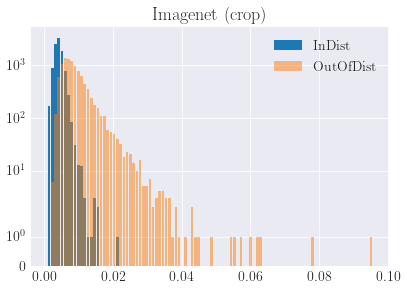

                          AUROC     AP-In     AP-Out  KL Divergence  \
Imagenet (crop) odin  78.259101  76.13001  79.054012       0.440086   

                      KL in P_lamb  
Imagenet (crop) odin      0.098673  



                             AUROC      AP-In     AP-Out  KL Divergence  \
Imagenet (resize) regret  96.65549  96.392131  96.933009       0.453706   

                          KL in P_lamb  
Imagenet (resize) regret      0.114758  


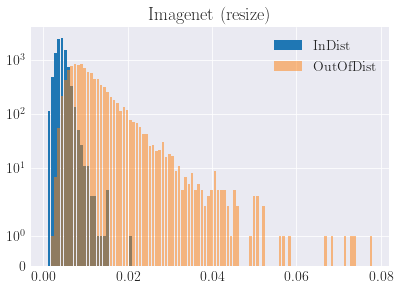

                            AUROC      AP-In     AP-Out  KL Divergence  \
Imagenet (resize) odin  60.272236  60.448779  58.561482       0.094439   

                        KL in P_lamb  
Imagenet (resize) odin       0.02271  



                        AUROC      AP-In     AP-Out  KL Divergence  \
LSUN (crop) regret  67.589978  69.331797  67.978143       2.557654   

                    KL in P_lamb  
LSUN (crop) regret      0.733107  


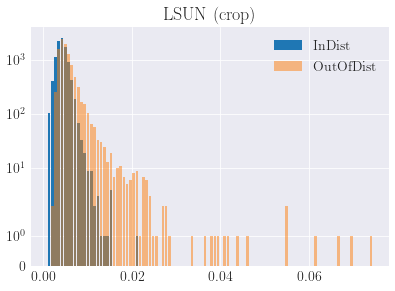

                      AUROC     AP-In     AP-Out  KL Divergence  KL in P_lamb
LSUN (crop) odin  83.123607  80.55559  84.801575       0.466364      0.113811



                          AUROC      AP-In     AP-Out  KL Divergence  \
LSUN (resize) regret  97.855527  97.887643  97.789474       0.839897   

                      KL in P_lamb  
LSUN (resize) regret      0.218019  


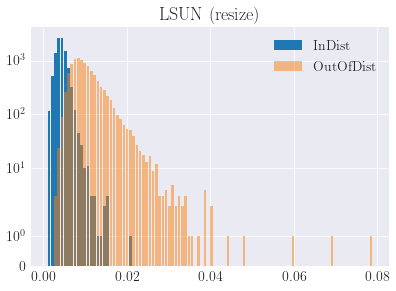

                        AUROC      AP-In     AP-Out  KL Divergence  \
LSUN (resize) odin  60.356302  60.444971  59.179033       0.040347   

                    KL in P_lamb  
LSUN (resize) odin      0.009289  



                 AUROC      AP-In     AP-Out  KL Divergence  KL in P_lamb
iSUN regret  97.539469  97.483322  97.598131        0.61403      0.158898


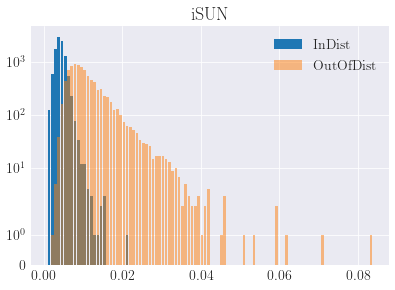

               AUROC      AP-In     AP-Out  KL Divergence  KL in P_lamb
iSUN odin  41.959968  44.443993  44.402754       0.093034      0.022129

Densnet CIFAR100:
                          AUROC  AP-In  AP-Out  KL Divergence  KL in P_lamb
Imagenet (crop) regret    92.79  92.25   93.39           1.53          0.41
Imagenet (crop) odin      78.26  76.13   79.05           0.44          0.10
Imagenet (resize) regret  96.66  96.39   96.93           0.45          0.11
Imagenet (resize) odin    60.27  60.45   58.56           0.09          0.02
LSUN (crop) regret        67.59  69.33   67.98           2.56          0.73
LSUN (crop) odin          83.12  80.56   84.80           0.47          0.11
LSUN (resize) regret      97.86  97.89   97.79           0.84          0.22
LSUN (resize) odin        60.36  60.44   59.18           0.04          0.01
iSUN regret               97.54  97.48   97.60           0.61          0.16
iSUN odin                 41.96  44.44   44.40           0.09          0.02


In [71]:
trainset_all = np.load(
    '../output/embeddings/densenet_cifar100_cifar100_train.npy').T
testset_ind = np.load(
    '../output/embeddings/densenet_cifar100_cifar100_test.npy').T
train_labels = np.load('../output/embeddings/cifar100_train_labels.npy')


max_prob_ind = np.load(
    '../output/embeddings/densenet_cifar100_cifar100_test_odin_baseline_max_prob.npy')

print('Labels {}'.format(len(np.unique(train_labels))))
performance_list = []
for (name, npy_regret_path), (_, npy_max_prob_path) in zip(datasets, datasets_baseline):

    # Regret
    performance, regret_ind_list, regret_ood_list = analyze_ind_ood_regret(trainset_all, train_labels, testset_ind,
                                                                           np.load(npy_regret_path).T)
    performance = performance.rename(index={0: name + ' regret'})
    print(performance)
    plot_ood(regret_ind_list, regret_ood_list, name)
    performance_list.append(performance)

    performance, regret_ind_list, regret_ood_list = analyze_ind_ood_max_prob(
        max_prob_ind, np.load(npy_max_prob_path))
    performance = performance.rename(index={0: name + ' odin'})
    print(performance)
    performance_list.append(performance)


result_cifar100 = pd.concat(performance_list)
print()
print('Densnet CIFAR100:')
print(result_cifar100.round(2))


## Densnet CIFAR10

Labels 10



                     AUROC      AP-In     AP-Out  KL Divergence  KL in P_lamb
Imagenet (crop)  97.440749  97.405059  97.593876      11.736068      2.240547


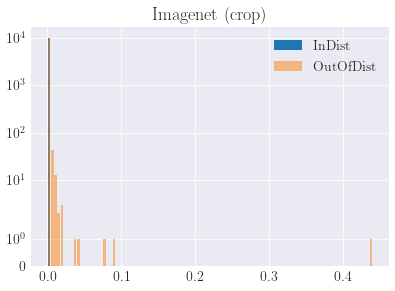


                       AUROC      AP-In     AP-Out  KL Divergence  \
Imagenet (resize)  96.688285  96.557273  96.818988      10.981363   

                   KL in P_lamb  
Imagenet (resize)       2.22725  


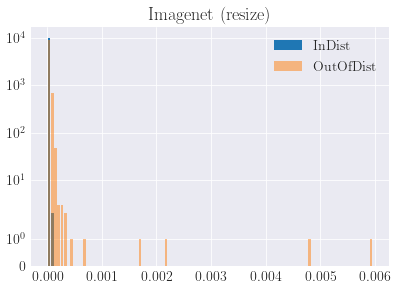


                 AUROC      AP-In     AP-Out  KL Divergence  KL in P_lamb
LSUN (crop)  94.315965  94.442337  94.475825       5.246784      1.715768


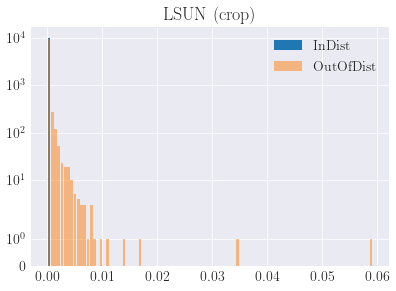


                   AUROC      AP-In     AP-Out  KL Divergence  KL in P_lamb
LSUN (resize)  97.956123  98.073359  97.790891      13.260812      2.342996


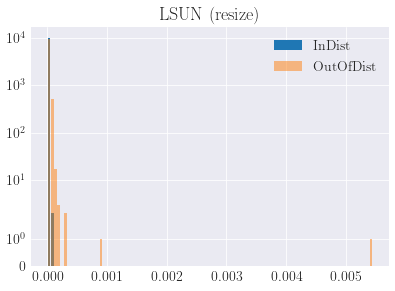


          AUROC      AP-In     AP-Out  KL Divergence  KL in P_lamb
iSUN  97.571352  97.552784  97.533161       7.586345      1.828769


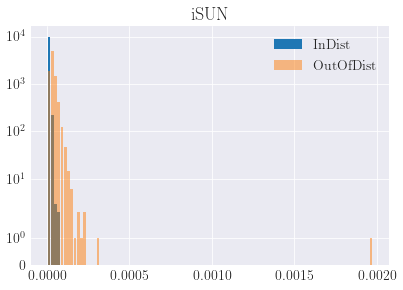

Densnet CIFAR10:
                   AUROC  AP-In  AP-Out  KL Divergence  KL in P_lamb
Imagenet (crop)    97.44  97.41   97.59          11.74          2.24
Imagenet (resize)  96.69  96.56   96.82          10.98          2.23
LSUN (crop)        94.32  94.44   94.48           5.25          1.72
LSUN (resize)      97.96  98.07   97.79          13.26          2.34
iSUN               97.57  97.55   97.53           7.59          1.83


In [6]:
trainset_all = np.load(
    '../output/embeddings/densenet_cifar10_cifar10_train.npy').T
testset_ind = np.load(
    '../output/embeddings/densenet_cifar10_cifar10_test.npy').T
train_labels = np.load('../output/embeddings/cifar10_train_labels.npy')


datasets = [('Imagenet (crop)', '../output/embeddings/densenet_cifar10_Imagenet_test.npy'),
            ('Imagenet (resize)',
             '../output/embeddings/densenet_cifar10_Imagenet_resize_test.npy'),
            ('LSUN (crop)', '../output/embeddings/densenet_cifar10_LSUN_test.npy'),
            ('LSUN (resize)', '../output/embeddings/densenet_cifar10_LSUN_resize_test.npy'),
            ('iSUN', '../output/embeddings/densenet_cifar10_iSUN_test.npy')
            ]
performance_list = []
print('Labels {}'.format(len(np.unique(train_labels))))
for (name, npy_path) in datasets:
    performance, regret_ind_list, regret_ood_list = analyze_ind_ood(trainset_all, train_labels, testset_ind,
                                                                    np.load(npy_path).T)
    performance = performance.rename(index={0: name})
    print(performance)
    plot_ood(regret_ind_list, regret_ood_list, name)
    performance_list.append(performance)
result_cifar10 = pd.concat(performance_list)
print('Densnet CIFAR10:')
print(result_cifar10.round(2))


## ODIN CIFAR100

Labels 100



                     AUROC      AP-In     AP-Out  KL Divergence  KL in P_lamb
Imagenet (crop)  93.993196  94.004429  94.098686       1.732045      0.467169


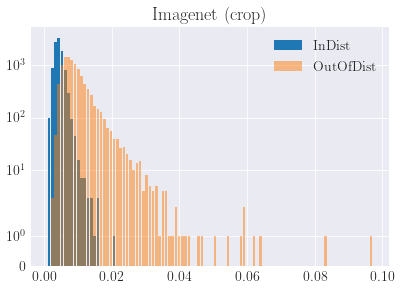


                       AUROC      AP-In     AP-Out  KL Divergence  \
Imagenet (resize)  96.536721  96.367235  96.750794       0.599147   

                   KL in P_lamb  
Imagenet (resize)      0.151583  


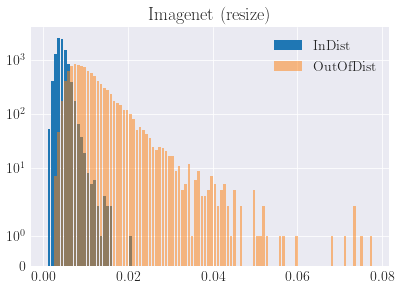


                 AUROC      AP-In     AP-Out  KL Divergence  KL in P_lamb
LSUN (crop)  80.533125  81.779367  79.065205       2.829066      0.777974


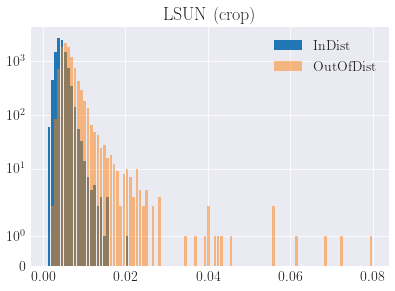


                   AUROC      AP-In     AP-Out  KL Divergence  KL in P_lamb
LSUN (resize)  97.559119  97.662399  97.443815       0.926287      0.238288


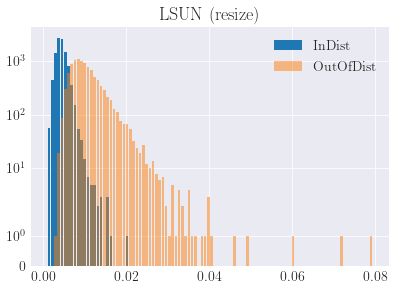


         AUROC      AP-In     AP-Out  KL Divergence  KL in P_lamb
iSUN  97.36272  97.435745  97.359995       0.844603      0.217132


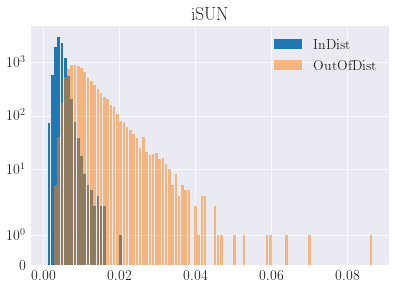

Densnet CIFAR100 with ODIN preprocess:
                   AUROC  AP-In  AP-Out  KL Divergence  KL in P_lamb
Imagenet (crop)    93.99  94.00   94.10           1.73          0.47
Imagenet (resize)  96.54  96.37   96.75           0.60          0.15
LSUN (crop)        80.53  81.78   79.07           2.83          0.78
LSUN (resize)      97.56  97.66   97.44           0.93          0.24
iSUN               97.36  97.44   97.36           0.84          0.22


In [10]:
trainset_all = np.load(
    '../output/embeddings/densenet_cifar100_cifar100_train.npy').T
testset_ind = np.load(
    '../output/embeddings/densenet_cifar100_cifar100_test_odin.npy').T
train_labels = np.load('../output/embeddings/cifar100_train_labels.npy')


datasets = [('Imagenet (crop)', '../output/embeddings/densenet_cifar100_Imagenet_test_odin.npy'),
            ('Imagenet (resize)',
             '../output/embeddings/densenet_cifar100_Imagenet_resize_test_odin.npy'),
            ('LSUN (crop)', '../output/embeddings/densenet_cifar100_LSUN_test_odin.npy'),
            ('LSUN (resize)',
             '../output/embeddings/densenet_cifar100_LSUN_resize_test_odin.npy'),
            ('iSUN', '../output/embeddings/densenet_cifar100_iSUN_test_odin.npy')
            ]
performance_list = []
print('Labels {}'.format(len(np.unique(train_labels))))
for (name, npy_path) in datasets:
    performance, regret_ind_list, regret_ood_list = analyze_ind_ood(trainset_all, train_labels, testset_ind,
                                                                    np.load(npy_path).T)
    performance = performance.rename(index={0: name})
    print(performance)
    plot_ood(regret_ind_list, regret_ood_list, name)
    performance_list.append(performance)
result_cifar100 = pd.concat(performance_list)
print('Densnet CIFAR100 with ODIN preprocess:')
print(result_cifar100.round(2))


## ODIN CIFAR10

Labels 10



                     AUROC     AP-In     AP-Out  KL Divergence  KL in P_lamb
Imagenet (crop)  97.897385  97.83568  98.015694       13.26051      2.341553


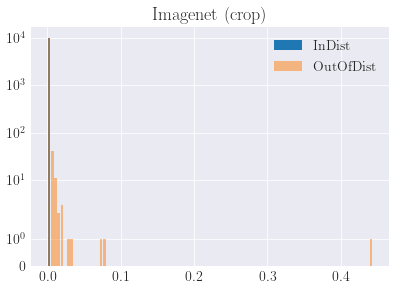


                       AUROC      AP-In     AP-Out  KL Divergence  \
Imagenet (resize)  96.841256  96.620083  97.016993      10.481326   

                   KL in P_lamb  
Imagenet (resize)      2.127032  


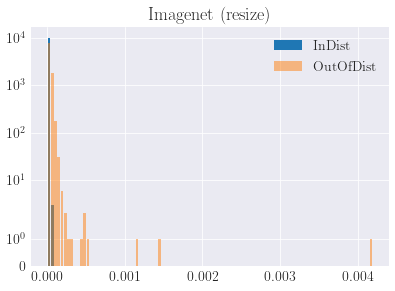


                 AUROC      AP-In     AP-Out  KL Divergence  KL in P_lamb
LSUN (crop)  96.299885  96.151956  96.505993       5.548375      1.793005


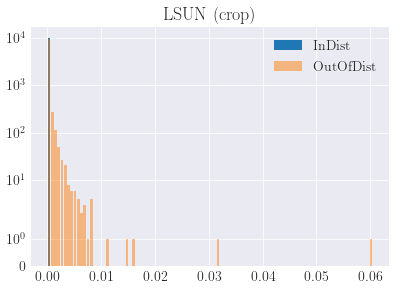


                   AUROC      AP-In     AP-Out  KL Divergence  KL in P_lamb
LSUN (resize)  98.180391  98.283753  98.056358      11.704344      2.375843


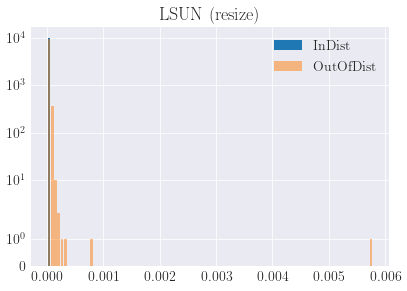


          AUROC      AP-In     AP-Out  KL Divergence  KL in P_lamb
iSUN  97.767036  97.749159  97.762977       9.671088      1.925139


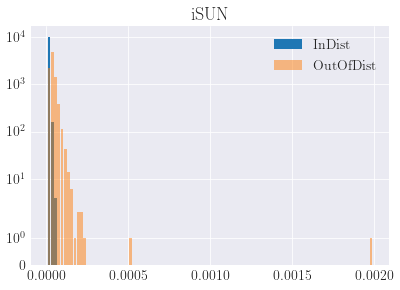

Densnet CIFAR10 with ODIN preprocess:
                   AUROC  AP-In  AP-Out  KL Divergence  KL in P_lamb
Imagenet (crop)    97.90  97.84   98.02          13.26          2.34
Imagenet (resize)  96.84  96.62   97.02          10.48          2.13
LSUN (crop)        96.30  96.15   96.51           5.55          1.79
LSUN (resize)      98.18  98.28   98.06          11.70          2.38
iSUN               97.77  97.75   97.76           9.67          1.93


In [11]:
trainset_all = np.load(
    '../output/embeddings/densenet_cifar10_cifar10_train.npy').T
testset_ind = np.load(
    '../output/embeddings/densenet_cifar10_cifar10_test_odin.npy').T
train_labels = np.load('../output/embeddings/cifar10_train_labels.npy')


datasets = [('Imagenet (crop)', '../output/embeddings/densenet_cifar10_Imagenet_test_odin.npy'),
            ('Imagenet (resize)',
             '../output/embeddings/densenet_cifar10_Imagenet_resize_test_odin.npy'),
            ('LSUN (crop)', '../output/embeddings/densenet_cifar10_LSUN_test_odin.npy'),
            ('LSUN (resize)',
             '../output/embeddings/densenet_cifar10_LSUN_resize_test_odin.npy'),
            ('iSUN', '../output/embeddings/densenet_cifar10_iSUN_test_odin.npy')
            ]
performance_list = []
print('Labels {}'.format(len(np.unique(train_labels))))
for (name, npy_path) in datasets:
    performance, regret_ind_list, regret_ood_list = analyze_ind_ood(trainset_all, train_labels, testset_ind,
                                                                    np.load(npy_path).T)
    performance = performance.rename(index={0: name})
    print(performance)
    plot_ood(regret_ind_list, regret_ood_list, name)
    performance_list.append(performance)
result_cifar10 = pd.concat(performance_list)
print('Densnet CIFAR10 with ODIN preprocess:')
print(result_cifar10.round(2))
